In [1]:
# NOTEBOOK OVERVIEW
# Cluster the skill requirements of job postings and
# visualize clusters using word clouds. Allowing for one
# to understand the different types of job requirements.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

import pandas as pd
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from wordcloud import WordCloud

import importlib
import random
import pickle
import gzip


In [3]:
# select which part of the job postings HTML likely contains 
# the listed skill requirements of a given posting

jobs_df = pd.read_pickle('data/sorted_trunc_jobs_df.pkl', 'zip')
jobs_df['bullets']

0     (Demonstrated ability to propose, initiate, an...
1                                                    ()
2     (Students will work with scientists, engineers...
3     (Leverage data to understand product, identify...
4     (Work on designing and implementing a framewor...
                            ...                        
95    (Analyze various data sets to build machine le...
96    (Use data visualization, statistical analysis,...
97    (Perform hands-on analysis of large volumes of...
98    (Apply your analytical skills to gain deep ins...
99    (Apply machine learning techniques to real-wor...
Name: bullets, Length: 100, dtype: object

In [4]:

skill_reqs = [i for subiter in jobs_df['bullets'] for i in subiter]

# store skill_reqs for more expedient use later in notebook 4_analysis
file = open('data/skill_reqs_list.pkl', 'wb')
pickle.dump(skill_reqs, file)
file.close()


In [5]:
# vectorize the skill requirements

vocab = TfidfVectorizer(stop_words='english')
freq_matrix = vocab.fit_transform(skill_reqs)
freq_matrix.shape

(1747, 2618)

In [6]:
# - reduce dimensionality with SVD/LSA 
# - docs recommend (SVD dimension) = 100 capturing enough variance 
#   to accomplish the given LSA task

svd = TruncatedSVD(n_components=100)
fm_reduc = svd.fit_transform(freq_matrix)
norm_fmr = Normalizer().fit_transform(fm_reduc)


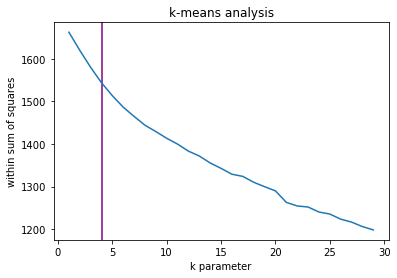

In [7]:
# - select appropriate cluster count for k-means
# - run algorithm using range of centroids, then analyze 
#   results and end goal of using k-means (creating 
#   job requirement clusters with right balance of 
#   scope versus focus in order to be useful)

k_range = range(1, 30)
within_sum_squares = [
    KMeans(n_clusters=k,
           n_init=20,
           random_state=0).fit(norm_fmr).inertia_ 
    for k in k_range]

pyplot = importlib.reload(pyplot)
pyplot.title('k-means analysis')
pyplot.xlabel('k parameter')
pyplot.ylabel('within sum of squares')
pyplot.axvline(x=4, color='purple')
pyplot.plot(k_range, within_sum_squares)

# after experimenting, let k = 4
k = 4
k_means = KMeans(n_clusters=k,
                 n_init=20,
                 random_state=0).fit(norm_fmr)

In [8]:
# collect clustering results

clust_labels_df = pd.DataFrame({'cluster':k_means.labels_})
clust_labels_df.to_pickle('data/clust_labels_df.pkl', 'zip')
print(clust_labels_df)

      cluster
0           1
1           1
2           1
3           0
4           1
...       ...
1742        0
1743        1
1744        1
1745        1
1746        1

[1747 rows x 1 columns]


In [9]:
# with word clouds visualize text clusters

In [10]:
def clust_to_img(clust_df):
    indexes = clust_df.index.values
    summed_score = np.asarray(freq_matrix[indexes].sum(axis=0))[0]
    data = {
        'word':vocab.get_feature_names(),
        'summed_tfidf_score':summed_score}
    scored_words_df = pd.DataFrame(data).sort_values(
        'summed_tfidf_score', ascending=False)

    cloud = WordCloud(
        max_words=13,
        random_state=0,
        background_color='white',
        color_func = lambda *args, **kwards:
            random.choice(('red','blue','purple','brown','black')))
    
    word_rank = {}; 
    for word, rank in scored_words_df.values:
        if rank != 0:
            word_rank[word] = rank
    
    cloud_img = cloud.fit_words(word_rank) 
    return scored_words_df, cloud_img
    

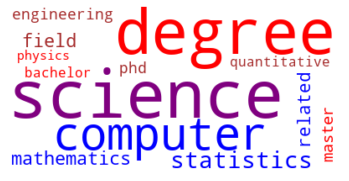

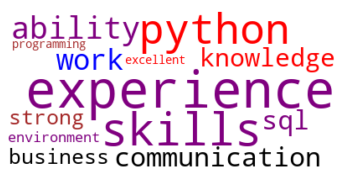

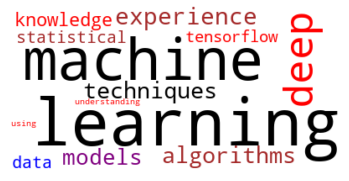

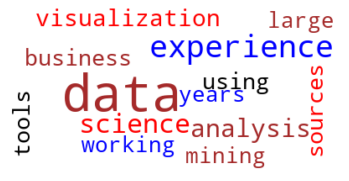

In [11]:
# display word clouds, see if they are sensible

clust_words = {}
for clust in range(k):
    clust_df = clust_labels_df[clust_labels_df.cluster == clust] 
    scored_words_df, cloud_img = clust_to_img(clust_df)
    
    clust_words[clust] = scored_words_df['word'].tolist()
    
    pyplot.imshow(cloud_img, interpolation='bilinear')
    pyplot.axis('off')
    pyplot.show()

# Results make sense, I can see a range of requirements that 
# are familiar. E.g. I see one cluster emphasizing undergraduate 
# and graduate degrees in quantitative areas and another
# highlighting communication/visualization of data.

# these can be thought of as job categories 


In [12]:
# save the displayed words of word cloud for notebook 4_analysis

file = open('data/clust_words.pkl', 'wb')
pickle.dump(clust_words, file)
file.close()